Modified from https://github.com/tiagoantao/bioinf-python/blob/master/notebooks/Interfacing_R.ipynb

## The next cell will get a ~65 MB data file 'sequence.index', you only need to run the cell once

In [1]:
!rm sequence.index 2>/dev/null
!wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/sequence.index

--2015-12-13 10:35:52--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/sequence.index
           => ‘sequence.index’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.192.8
접속 ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.192.8|:21... 접속됨.
Logging in as anonymous ... 로그인 완료!
==> SYST ... done.    ==> PWD ... 마침.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp ... 마침.
==> SIZE sequence.index ... 마침.
==> PASV ... done.    ==> RETR sequence.index ... 
No such file ‘sequence.index’.



Ref)
ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data/README_data_has_moved.md

'### How do I find where my file has gone?

We keep a tree file which lists all the files currently on the FTP site. It is called current.tree ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/current.tree. We also keep complete changelogs which list all the changes that have been made to the ftp site each day, these files can be found in ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/changelog_details/.
If you have a file name, you should be able to search the current.tree file for the file and find its new location. If you don't have the file name but can remember what the file contained, please email info@1000genomes.org to ask for help.


ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/current.tree
ftp/historical_data/former_toplevel/sequence.index	file	67069489	Tue Dec  3 21:16:30 2013	ca938e55a5525efeaa743af66a28a87e

ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index


In [1]:
!rm sequence.index 2>/dev/null
!wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index

--2015-12-15 05:39:16--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index
           => ‘sequence.index’
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.192.8
접속 ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.192.8|:21... 접속됨.
Logging in as anonymous ... 로그인 완료!
==> SYST ... done.    ==> PWD ... 마침.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/historical_data/former_toplevel ... 마침.
==> SIZE sequence.index ... 67069489
==> PASV ... done.    ==> RETR sequence.index ... 마침.
길이 : 67069489 (64M) (unauthoritative)

100%[======================================>] 67,069,489   321KB/s   in 92s    

2015-12-15 05:40:52 (715 KB/s) - ‘sequence.index’ saved [67069489]



# Interfacing with R

In [2]:
import os

import rpy2.robjects as robjects

##### 1.We start by importing rpy2 and reading the file, using the read_delim R function:

In [3]:
read_delim = robjects.r('read.delim')
seq_data = read_delim('sequence.index', header=True, stringsAsFactors=False)
#In R:
#  seq.data <- read.delim('sequence.index', header=TRUE, stringsAsFactors=FALSE) #read.delim R function allows you to read files.

##### 2.Then, we call the function proper
First, most atomic objects—such as strings—can be passed without conversion.

Second, argument names are converted seamlessly (barring the dot issue).

Finally, objects are available in the Python namespace (but objects are actually not available in the R
namespace; more about this later).

In [4]:
print('This data frame has %d columns and %d rows' % (seq_data.ncol, seq_data.nrow)) #seq_data : data frame

This data frame has 26 columns and 187720 rows


In [5]:
print(seq_data.colnames)
#In R:
#  print(colnames(seq.data))
#  print(nrow(seq.data))
#  print(ncol(seq.data))

 [1] "FASTQ_FILE"          "MD5"                 "RUN_ID"             
 [4] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [7] "SUBMISSION_ID"       "SUBMISSION_DATE"     "SAMPLE_ID"          
[10] "SAMPLE_NAME"         "POPULATION"          "EXPERIMENT_ID"      
[13] "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"    "LIBRARY_NAME"       
[16] "RUN_NAME"            "RUN_BLOCK_NAME"      "INSERT_SIZE"        
[19] "LIBRARY_LAYOUT"      "PAIRED_FASTQ"        "WITHDRAWN"          
[22] "WITHDRAWN_DATE"      "COMMENT"             "READ_COUNT"         
[25] "BASE_COUNT"          "ANALYSIS_GROUP"     



In [6]:
print('Columns in Python %d ' % robjects.r.ncol(seq_data)[0]) #[26] which is a vector composed of the element 26. This is because by default, most operations in R return vectors.

Columns in Python 26 


##### 3.Now, we need to perform some data cleanup. For example, some columns should be interpreted as numbers, but they are read as strings:

In [7]:
#access some functions
as_integer = robjects.r('as.integer')
match = robjects.r.match

my_col = match('READ_COUNT', seq_data.colnames)[0] # Vector returned
print('Type of read count before as.integer: %s' % seq_data[my_col - 1].rclass[0])

Type of read count before as.integer: character


In [8]:
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
print('Type of read count after as.integer: %s' % seq_data[my_col - 1].rclass[0])

Type of read count after as.integer: integer


In [9]:
my_col = match('BASE_COUNT', seq_data.colnames)[0] # Vector returned
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])

my_col = match('CENTER_NAME', seq_data.colnames)[0]
seq_data[my_col - 1] = robjects.r.toupper(seq_data[my_col - 1])

##### 4.We will need to massage this table a bit more; details can be found on a notebook, but here we will finalize with getting the data frame to R (remember that while it's an R object, it's actually visible on the Python namespace only):

In [10]:
robjects.r.assign('seq.data', seq_data)
#This will create a variable in the R namespace called seq.data with the content of the data frame from the Python namespace.
#Note that after this operation, both objects will be independent (if you change one, it will not be reflected on the other).
robjects.r('print(c("Column names in R: ",colnames(seq.data)))')

 [1] "Column names in R: " "FASTQ_FILE"          "MD5"                
 [4] "RUN_ID"              "STUDY_ID"            "STUDY_NAME"         
 [7] "CENTER_NAME"         "SUBMISSION_ID"       "SUBMISSION_DATE"    
[10] "SAMPLE_ID"           "SAMPLE_NAME"         "POPULATION"         
[13] "EXPERIMENT_ID"       "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"   
[16] "LIBRARY_NAME"        "RUN_NAME"            "RUN_BLOCK_NAME"     
[19] "INSERT_SIZE"         "LIBRARY_LAYOUT"      "PAIRED_FASTQ"       
[22] "WITHDRAWN"           "WITHDRAWN_DATE"      "COMMENT"            
[25] "READ_COUNT"          "BASE_COUNT"          "ANALYSIS_GROUP"     


<StrVector - Python:0x7fbc300c7b90 / R:0x32ceed0>
[str, str, str, ..., str, str, str]

##### Example based on the Human 1000 genomes project

In [11]:
robjects.r('seq.data <- seq.data[seq.data$WITHDRAWN==0, ]')
#Lets remove all withdrawn sequences

robjects.r("seq.data <- seq.data[, c('STUDY_ID', 'STUDY_NAME', 'CENTER_NAME', 'SAMPLE_ID', 'SAMPLE_NAME', 'POPULATION', 'INSTRUMENT_PLATFORM', 'LIBRARY_LAYOUT', 'PAIRED_FASTQ', 'READ_COUNT', 'BASE_COUNT', 'ANALYSIS_GROUP')]")
#Lets shorten the dataframe

#Population as factor
robjects.r('seq.data$POPULATION <- as.factor(seq.data$POPULATION)')

<FactorVector - Python:0x7fbc300c7878 / R:0x4eb0150>
[      27,       27,       27, ...,       25,       25,       25]

##### 5.R integration example with a plot using ggplot2.
##### 6. Plot a histogram with the distribution of center names, where all sequencing lanes were generated.
##### 7. Use ggplot to create a chart.
##### 8. Specify the seq_data data frame, then use a histogram bar plot called geom_bar, followed by annotating the X variable(CENTER_NAME).
##### 9. Rotate the text of the x axis by changing the theme.

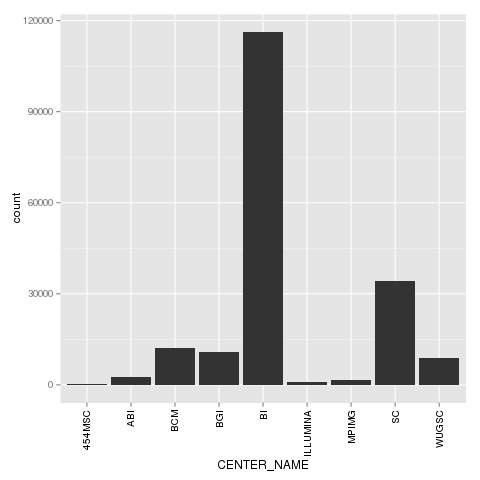

In [12]:
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects.functions import SignatureTranslatedFunction

ggplot2.theme = SignatureTranslatedFunction(ggplot2.theme,
                                            init_prm_translate = {'axis_text_x': 'axis.text.x'})
bar = ggplot2.ggplot(seq_data) + ggplot2.geom_bar() + ggplot2.aes_string(x='CENTER_NAME') + ggplot2.theme(axis_text_x=ggplot2.element_text(angle=90, hjust=1))
robjects.r.png('out.png') #R png(): output the chart to a PNG file.
bar.plot()
dev_off = robjects.r('dev.off')
dev_off()

from IPython.display import Image
Image(filename='out.png')

##### 10. Scatter plot of read and base counts for all the sequenced lanes for Yoruban (YRI) and Utah residents with ancestry from Northern and Western Europe (CEU) of the Human 1000 genomes project. The difference among the different types of sequencing (exome, high, and low coverage). We first generate a data frame with just YRI and CEU lanes and limit the maximum base and read counts:

In [13]:
#Get Yoruba and CEU
robjects.r('yri_ceu <- seq.data[seq.data$POPULATION %in% c("YRI", "CEU") & seq.data$BASE_COUNT < 2E9 & seq.data$READ_COUNT < 3E7, ]')
yri_ceu = robjects.r('yri_ceu')

#robjects.r('yri_ceu$POPULATION <- as.factor(yri_ceu$POPULATION)')
#robjects.r('yri_ceu$ANALYSIS_GROUP <- as.factor(yri_ceu$ANALYSIS_GROUP)')

##### 11. Plot => easy to express that the shape of each point depends on the POPULATION variable and the color on the ANALYSIS_GROUP:

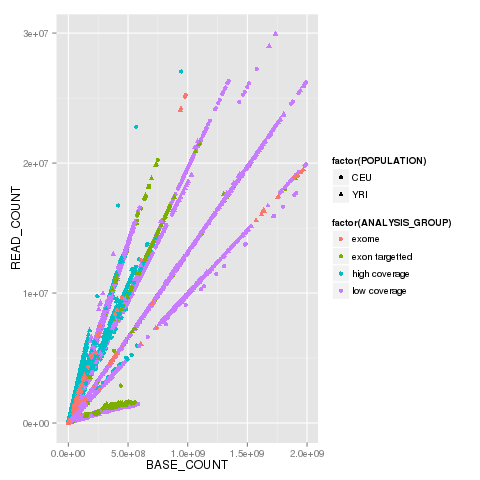

In [14]:
scatter = ggplot2.ggplot(yri_ceu) + ggplot2.aes_string(x='BASE_COUNT', y='READ_COUNT', shape='factor(POPULATION)', col='factor(ANALYSIS_GROUP)') + ggplot2.geom_point()
robjects.r.png('out.png')
scatter.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out.png')

##### 12. pandas: R-inspired Python library designed with data analysis and modeling => fundamental data structures in pandas is (surprise) the data frame

In [15]:
import pandas as pd
import pandas.rpy.common as pd_common
pd_yri_ceu = pd_common.load_data('yri_ceu')
print(type(pd_yri_ceu))
pd_yri_ceu

<class 'pandas.core.frame.DataFrame'>


/home/deepbio/anaconda/envs/bioinformatics/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  from ipykernel import kernelapp as app


,STUDY_ID,STUDY_NAME,CENTER_NAME,SAMPLE_ID,SAMPLE_NAME,POPULATION,INSTRUMENT_PLATFORM,LIBRARY_LAYOUT,PAIRED_FASTQ,READ_COUNT,BASE_COUNT,ANALYSIS_GROUP
1,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9280498,334097928,high coverage
2,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9571982,344591352,high coverage
3,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,,149044,5365584,high coverage
4,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,data/NA19240/sequence_read/ERR000020_2.filt.fa...,2057690,74076840,high coverage
5,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,data/NA19240/sequence_read/ERR000020_1.filt.fa...,2057690,74076840,high coverage
6,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9388168,337974048,high coverage
7,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,7762958,279466488,high coverage
8,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9625450,385018000,high coverage
9,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,8808642,317111112,high coverage
10,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,,15187,683415,high coverage


In [16]:
del pd_yri_ceu['PAIRED_FASTQ'] #delete the column that indicates the name of the paired FASTQ file on the pandas data frame
no_paired = pd_common.convert_to_r_dataframe(pd_yri_ceu) #copy it back to the R namespace.
robjects.r.assign('no.paired', no_paired)
robjects.r("print(colnames(no.paired))")

 [1] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [4] "SAMPLE_ID"           "SAMPLE_NAME"         "POPULATION"         
 [7] "INSTRUMENT_PLATFORM" "LIBRARY_LAYOUT"      "READ_COUNT"         
[10] "BASE_COUNT"          "ANALYSIS_GROUP"     


<StrVector - Python:0x7fbc199947a0 / R:0x991dd20>
[str, str, str, ..., str, str, str]

Ref) R packages for bioinformatics in the Bioconductor project (http://www.bioconductor.org/).

R packages on CRAN (Comprehensive R Archive Network at http://cran.r-project.org/).

ggplot2-like implementation for Python based on the Grammar of Graphics description language for charts and this is called—surprise-surprise—ggplot! (http://ggplot.yhathq.com/).

** See also **
- Plenty of tutorials and books on R; check the R web page (http://www.r-project.org/) for documentation.
- Bioconductor documentation at http://manuals.bioinformatics.ucr.edu/home/R_BioCondManual.
- High Throughput Sequence Analysis with Bioconductor at http://manuals.bioinformatics.ucr.edu/home/ht-seq.
- rpy library documentation at http://rpy.sourceforge.net/.
- The Grammar of Graphics is described in a book aptly named The Grammar of Graphics, Leland Wilkinson, Springer.
- pandas library tutorials at http://pandas.pydata.org/pandasdocs/dev/tutorials.html. The book, Python for Data Analysis, Wes McKinney, O'Reilly Media